In [1]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the data from a CSV

# Configure data Types for the DataFrame creation.  Integers are left out because NaNs generate an error
dtypes = {'ID': str, 
          'Device ID': str, 
          'Vehicle Type': 'category', 
          'Trip Duration': float, 
          'Trip Distance': float, 
          'Census Tract Start': str, 
          'Census Tract End': str}

# Configure ID as the index column.
index_cols = ['ID']

# Create the dataframe.
scooters = pd.read_csv('Shared_Micromobility_Vehicle_Trips.csv', dtype=dtypes, index_col=index_cols)

In [3]:
# Remove e-bikes, which are out of scope of this project:
total_rows = scooters.shape[0]
scooters = scooters[scooters['Vehicle Type'] == 'scooter']
e_bikes_dropped = total_rows - scooters.shape[0]
print('E-Bikes dropped: ' + str(e_bikes_dropped))

E-Bikes dropped: 338834


In [4]:
# Save the size of the original dataframe
total_rows = scooters.shape[0]
print('Original scooter entries: ' + str(total_rows))

Original scooter entries: 6510117


In [5]:
# Find which columns have na values (commented for cleaner output)
# print(scooters.isna().any())

# Initialize rows_remaining to count as rows are removed
rows_remaining = scooters.shape[0]

In [6]:
'''Remove rows for which date time, Census Tract End or Census Tract Start are empty.
The entire row should be removed because prediction will not be possible on rows missing this information.
It also does not make sense to fill these columns, as every trip/row is a discrete event.'''
scooters = scooters.dropna(how='any', subset=['Start Time', 'End Time', 'Vehicle Type','Census Tract Start', 'Census Tract End'])

# Determine how many rows were removed.
na_rows_dropped = rows_remaining - scooters.shape[0]
rows_remaining = scooters.shape[0]
print('NA rows dropped: ' + str(na_rows_dropped))


# Check if any Na values remain. (Commented to clean output)
# print(scooters.isna().any())

NA rows dropped: 130


In [7]:
# Now these columns can be converted to int (importing as int generated errors from the NaN values):
scooters['Day of Week'] = scooters['Day of Week'].astype('int8')
scooters['Month'] = scooters['Month'].astype('int8')
scooters['Hour'] = scooters['Hour'].astype('int8')
scooters['Year'] = scooters['Year'].astype('int16')

In [8]:
# %%time 

# Convert date columns to datetimes. 
# Do this instead of parse_dates in read_csv to take advantage of any reduced number of rows.
# This also allows format to be specified, which runs faster than making pandas guess the format.
scooters['Start Time'] = pd.to_datetime(scooters['Start Time'], format='%m/%d/%Y %I:%M:%S %p')
scooters['End Time'] = pd.to_datetime(scooters['End Time'], format='%m/%d/%Y %I:%M:%S %p')
scooters['Modified Date'] = pd.to_datetime(scooters['Modified Date'], format='%m/%d/%Y %I:%M:%S %p')

In [9]:
# Use describe to search for outliers
scooters.describe()

,Trip Duration,Trip Distance,Month,Hour,Day of Week,Council District (Start),Council District (End),Year
count,6.509987e+06,6.509987e+06,6.509987e+06,6.509987e+06,6.509987e+06,6.509987e+06,6.509987e+06,6.509987e+06
mean,6.475654e+02,2.453379e+04,6.385089e+00,1.469741e+01,3.256158e+00,7.757887e+00,7.687659e+00,2.018658e+03
std,1.842794e+03,6.423460e+06,3.160754e+00,5.044591e+00,2.092815e+00,2.587293e+00,2.641701e+00,4.744855e-01
min,-3.423000e+03,-1.672411e+07,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.018000e+03
25%,2.280000e+02,4.370000e+02,4.000000e+00,1.200000e+01,1.000000e+00,9.000000e+00,9.000000e+00,2.018000e+03
50%,3.960000e+02,9.650000e+02,6.000000e+00,1.500000e+01,3.000000e+00,9.000000e+00,9.000000e+00,2.019000e+03
75%,7.380000e+02,1.818000e+03,9.000000e+00,1.800000e+01,5.000000e+00,9.000000e+00,9.000000e+00,2.019000e+03
max,1.888695e+06,2.147480e+09,1.200000e+01,2.300000e+01,6.000000e+00,1.000000e+01,1.000000e+01,2.019000e+03


In [10]:
# Remove any rows that started or ended out of bounds
scooters = scooters[~scooters['Census Tract Start'].str.contains('OUT_OF_BOUNDS')]
scooters = scooters[~scooters['Census Tract End'].str.contains('OUT_OF_BOUNDS')]

# Get number of rows dropped
oob_rows_dropped = rows_remaining - scooters.shape[0]
rows_remaining = scooters.shape[0]
print('Out of Bounds entries dropped: ' + str(oob_rows_dropped))

Out of Bounds entries dropped: 52981


Before removing outliers:


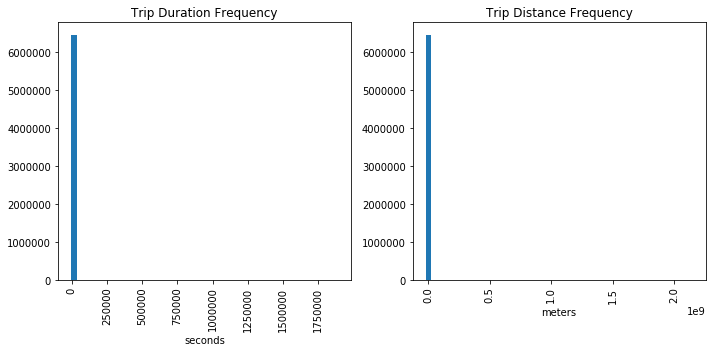

In [11]:
print('Before removing outliers:')

# Describe showed some negative and very high values for Trip Distance and Trip Duration.
# Use histograms to show how the values are distributed.

plt.figure(figsize=[10, 5])
plt.subplot(1,2,1)
plt.hist(scooters['Trip Duration'], bins=50, )
plt.xlabel('seconds')
plt.title('Trip Duration Frequency')
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.hist(scooters['Trip Distance'], bins=50)
plt.xlabel('meters')
plt.title('Trip Distance Frequency')
plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()
plt.close()

In [12]:
# Describe showed negative trip duration values. Remove these entries
scooters = scooters[scooters['Trip Duration'] > 0]

# Get number of rows dropped
neg_dur_rows_dropped = rows_remaining - scooters.shape[0]
rows_remaining = scooters.shape[0]
print('Negative duration dropped: ' + str(neg_dur_rows_dropped))

# Drop > a certain number of hours
time_thresh = 43200
scooters = scooters[scooters['Trip Duration'] < time_thresh]
high_dur_rows_dropped = rows_remaining - scooters.shape[0]
rows_remaining = scooters.shape[0]
print('Over ' + str(time_thresh/3600) + ' hours dropped: ' + str(high_dur_rows_dropped))

# Describe showed negative trip distance values. Remove these entries, and trips of 0 m.
scooters = scooters[scooters['Trip Distance'] > 0]
neg_dist_rows_dropped = rows_remaining - scooters.shape[0]
rows_remaining = scooters.shape[0]
print('Negative or 0 distance dropped: ' + str(neg_dist_rows_dropped))

# Remove entries over a certain amount for trip distance.  Average scooter battery range is 30 mi, with some capable of 50 mi.
dist_thresh = 80467.2
scooters = scooters[scooters['Trip Distance'] < dist_thresh]
high_dist_rows_dropped = rows_remaining - scooters.shape[0]
rows_remaining = scooters.shape[0]
print('Distance > ' + str(dist_thresh * 0.000621371) + ' mi dropped: ' + str(high_dist_rows_dropped))

Negative duration dropped: 1028
Over 12.0 hours dropped: 262
Negative or 0 distance dropped: 505391
Distance > 49.9999845312 mi dropped: 965


After removing outliers:


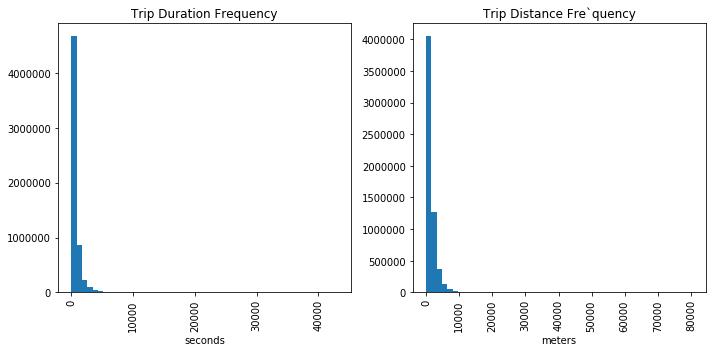

In [13]:
# Generate histograms to show effect of removing outliers

print('After removing outliers:')
plt.figure(figsize=[10, 5])
plt.subplot(1,2,1)
plt.hist(scooters['Trip Duration'], bins=50)
plt.xlabel('seconds')
plt.title('Trip Duration Frequency')
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.hist(scooters['Trip Distance'], bins=50)
plt.xlabel('meters')
plt.title('Trip Distance Fre`quency')
plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()
plt.close()

In [14]:
# print number of rows dropped
print('Total entries remaining: ' + str(rows_remaining))
print('Percent removed: ' + str(((total_rows - rows_remaining)/total_rows)*100.00) + '%')

Total entries remaining: 5949360
Percent removed: 8.61362399477613%


In [15]:
# Print the data types to show each column is the correct type.
print('Column Data types:')
print(scooters.dtypes)

Column Data types:
Device ID                           object
Vehicle Type                      category
Trip Duration                      float64
Trip Distance                      float64
Start Time                  datetime64[ns]
End Time                    datetime64[ns]
Modified Date               datetime64[ns]
Month                                 int8
Hour                                  int8
Day of Week                           int8
Council District (Start)           float64
Council District (End)             float64
Year                                 int16
Census Tract Start                  object
Census Tract End                    object
dtype: object
